In [78]:
import pandas as pd
from collections import Counter
from itertools import combinations
import scipy.stats as stats
from scipy.stats import mannwhitneyu

import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
import numpy as np 
import pandas as pd

In [79]:
good_data = pd.read_csv("data/norm/dataset/csv/paper_authors.csv")
vote_result_good = pd.read_csv('data/norm/dataset/csv/vote_results.csv')
pred_data = pd.read_csv("data/pred/dataset/csv/paper_authors.csv")
vote_result_pred = pd.read_csv('data/pred/dataset/csv/vote_results.csv')

In [80]:
merged_data_pred = pred_data.merge(vote_result_pred, on ="paper_id")

In [81]:
merged_data_good = good_data.merge(vote_result_good, on ="paper_id")

<h3>Filter and Graph</h3>

In [82]:
from collections import Counter

def count_exact_author_groups(df):
    """
    Counts how many times each exact group of authors collaborated together.
    """
    paper_authors = df.groupby('paper_id')['author_id'].apply(set)

    # Step 2: Use frozenset to make author groups hashable and countable
    group_counter = Counter(frozenset(authors) for authors in paper_authors)

    group_df = pd.DataFrame([
        {'author_group': list(group), 'group_size': len(group), 'count': count}
        for group, count in group_counter.items()
        if len(group) > 1  # optional: skip solo authors
    ]).sort_values(by='count', ascending=False).reset_index(drop=True)

    return group_df

In [83]:
result = count_exact_author_groups(good_data)
filter_result_good = result[result['count'] > 4]

In [84]:
filter_result_good # good dataset group of authors collaborate >= 5 times

,author_group,group_size,count
0,"[11219, 11220]",2,11
1,"[5064, 5063]",2,8
2,"[14875, 14876]",2,7
3,"[9066, 9082, 9069, 9070, 9071]",5,6


In [85]:
result_pred = count_exact_author_groups(pred_data)
filter_result_pred = result_pred[result_pred['count'] > 4]

In [86]:
filter_result_pred # pred dataset group of authors collaborate >= 5 times

,author_group,group_size,count
0,"[10936, 10940, 14422]",3,54
1,"[105, 107, 3308, 1844]",4,19
2,"[604, 605]",2,16
3,"[600, 601, 602, 3151]",4,12
4,"[116, 3294, 119]",3,12
...,...,...,...
82,"[12914, 13668, 13669, 2630, 13670]",5,5
83,"[5634, 5635, 3256, 1485, 1486]",5,5
84,"[1097, 1098, 1099]",3,5
85,"[105, 3308, 103]",3,5


<h3>Entire Collaboration Network</h3>

In [ ]:
import pandas as pd
import networkx as nx
from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def collaboration_network_graph(
    df,
    collaboration_threshold=3,
    filter_type="greater",
    ax=None,
    save_csv=True,
    csv_path="data/communities_output.csv"
):
    # Extract collaborations (pairwise combinations of authors for each paper)
    collaborations = []
    for _, group in df.groupby("paper_id")["author_id"]:
        collaborations.extend(combinations(group, 2))

    # Count collaborations
    collaboration_counts = Counter(collaborations)
    
    # Filter collaborations based on the threshold and filter_type
    if filter_type == "greater":
        filtered_collaborations = {
            pair: count for pair, count in collaboration_counts.items() if count >= collaboration_threshold
        }
    elif filter_type == "less":
        filtered_collaborations = {
            pair: count for pair, count in collaboration_counts.items() if 1 < count < collaboration_threshold
        }
    else:
        raise ValueError("Invalid filter_type. Choose 'greater' or 'less'.")
    
    G = nx.Graph()
    for (author1, author2), weight in filtered_collaborations.items():
        G.add_edge(author1, author2, weight=weight)
    
    # Filter authors present in the graph
    filtered_authors = set(G.nodes())
    filtered_data = df[df["author_id"].isin(filtered_authors)]
    
    # Calculate percentage of AI decisions for each author
    ai_percentage = (
        filtered_data.groupby("author_id")["final_decision"]
        .apply(lambda x: (x == "AI").mean() * 100)
        .reset_index(name="ai_percentage")
    )
    ai_percentage_dict = dict(zip(ai_percentage["author_id"], ai_percentage["ai_percentage"]))

    # Calculate node sizes based on the number of papers written
    filtered_author_papers = filtered_data.groupby("author_id")["paper_id"].nunique()
    node_sizes = {
        author: filtered_author_papers.get(author, 0) * 10
        for author in G.nodes()
    }
    
    # Calculate node weights based on collaboration strength
    node_weights = {
        node: sum(d['weight'] for _, _, d in G.edges(node, data=True))
        for node in G.nodes()
    }
    
    # Add AI percentage and node weights as node attributes
    for node in G.nodes():
        G.nodes[node]["ai_percentage"] = ai_percentage_dict.get(node, 0)
        G.nodes[node]["collaboration_weight"] = node_weights[node]
    
    # Authors who can reach each other via the qualifying edge are all in the same community.
    components = [sorted(comp) for comp in nx.connected_components(G)]
    components.sort(key=lambda c: (-len(c), c))

    print(f"detected：{len(components)} communities")
    rows = []
    for i, members in enumerate(components, 1):
        print(f"[community {i}] author counts={len(members)}，members={members}")
        for author in members:
            rows.append({"community_id": i, "author_id": author})

    if save_csv and rows:
        df_out = pd.DataFrame(rows)
        df_out.to_csv(csv_path, index=False)
        print(f"\nfile saved:{csv_path}")
    elif save_csv:
        print("\nfailed")
    
    # Visualize the graph
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 10))
        
    pos = nx.spring_layout(G, seed=42, k=0.8)  # Use spring layout for spacing

    # Normalize AI percentages to a fixed scale of 1–100
    norm = mcolors.Normalize(vmin=1, vmax=100)
    cmap = plt.cm.YlOrRd

    node_colors = [cmap(norm(max(1, min(G.nodes[node].get("ai_percentage", 0), 100)))) for node in G.nodes()]
    
    nx.draw_networkx_nodes(
        G, pos,
        node_size=[node_sizes[node] for node in G.nodes()],
        node_color=node_colors,
        ax=ax,
    )
    nx.draw_networkx_edges(
        G, pos,
        edge_color="gray",
        width=[(G[u][v]["weight"] / max(1, collaboration_threshold)) ** 1.5 for u, v in G.edges()],
        ax=ax,
    )
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label="Percentage of AI Decisions (%)")
    
    ax.set_title(
        f"Collaboration Network with AI Decision Heatmap\n"
        f"(Threshold: {filter_type} {collaboration_threshold})"
    )

    if ax is None:
        plt.show()

    return G

detected：30 communities
[community 1] author counts=9，members=[1232, 5490, 5491, 5815, 5977, 5978, 6193, 6195, 6221]
[community 2] author counts=6，members=[12, 2219, 2220, 2221, 2222, 2223]
[community 3] author counts=5，members=[6148, 15188, 15200, 15316, 15493]
[community 4] author counts=4，members=[1361, 4425, 19279, 19280]
[community 5] author counts=4，members=[6704, 12474, 12475, 12476]
[community 6] author counts=4，members=[8009, 8019, 8135, 8191]
[community 7] author counts=4，members=[17028, 17029, 17046, 17047]
[community 8] author counts=3，members=[4919, 7943, 9407]
[community 9] author counts=3，members=[6691, 6724, 6742]
[community 10] author counts=3，members=[7193, 7194, 7195]
[community 11] author counts=3，members=[9066, 9070, 9071]
[community 12] author counts=3，members=[13528, 13538, 13561]
[community 13] author counts=3，members=[19634, 19661, 19662]
[community 14] author counts=2，members=[1, 2]
[community 15] author counts=2，members=[18, 1942]
[community 16] author counts

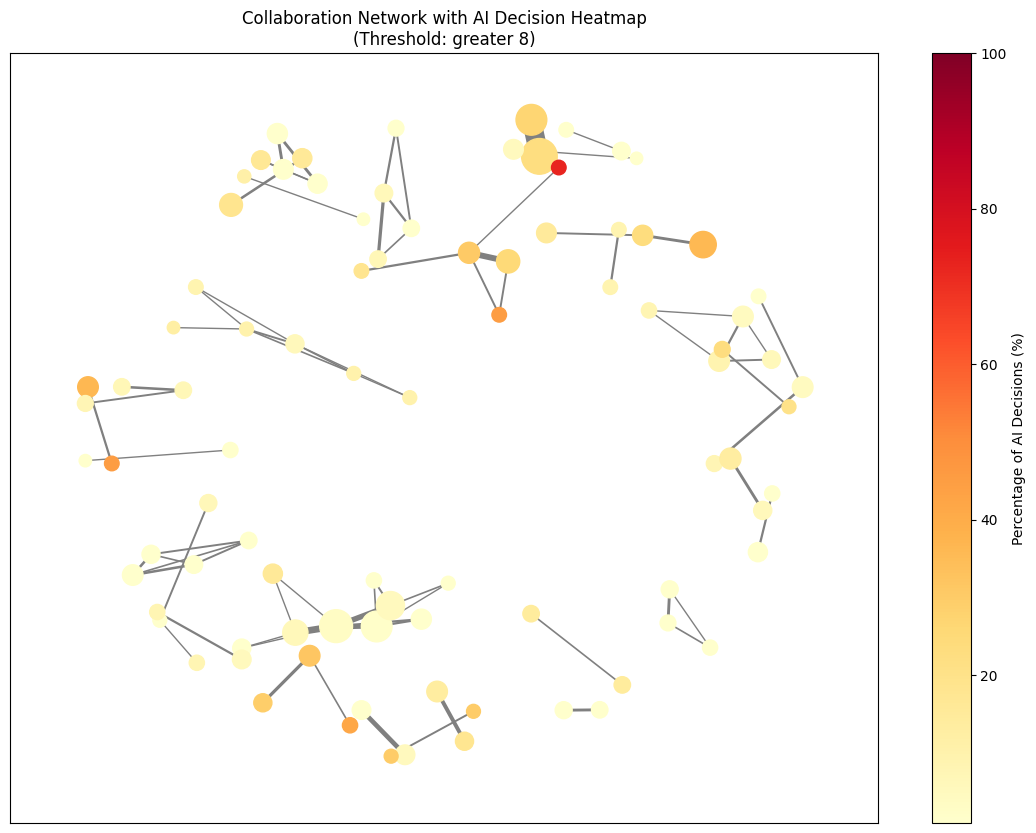

In [88]:
collaboration_network_graph(merged_data_good, collaboration_threshold=8, filter_type="greater", csv_path="data/norm/metadata/communities_output.csv")

detected：42 communities
[community 1] author counts=23，members=[616, 1041, 1042, 1043, 1044, 1045, 1070, 1071, 1076, 1077, 1078, 1079, 1086, 1175, 1176, 1292, 1293, 1614, 2386, 2771, 2792, 5886, 7340]
[community 2] author counts=19，members=[93, 116, 117, 119, 382, 682, 683, 685, 1047, 1050, 1051, 1095, 1096, 1590, 3242, 3256, 3294, 5634, 5635]
[community 3] author counts=14，members=[1048, 1055, 1059, 1060, 1087, 1167, 1168, 1388, 1491, 1882, 2351, 2392, 5894, 12443]
[community 4] author counts=12，members=[69, 70, 100, 619, 664, 1194, 1915, 1916, 4251, 4256, 4887, 4888]
[community 5] author counts=12，members=[82, 621, 1046, 1068, 1069, 1080, 1084, 1180, 1181, 1186, 5887, 5888]
[community 6] author counts=9，members=[84, 599, 1159, 1160, 1275, 1431, 1432, 1433, 1434]
[community 7] author counts=9，members=[9116, 9117, 9264, 9266, 9281, 9383, 9735, 9766, 9770]
[community 8] author counts=8，members=[91, 606, 607, 1035, 1425, 1428, 1430, 1472]
[community 9] author counts=7，members=[52, 77, 78

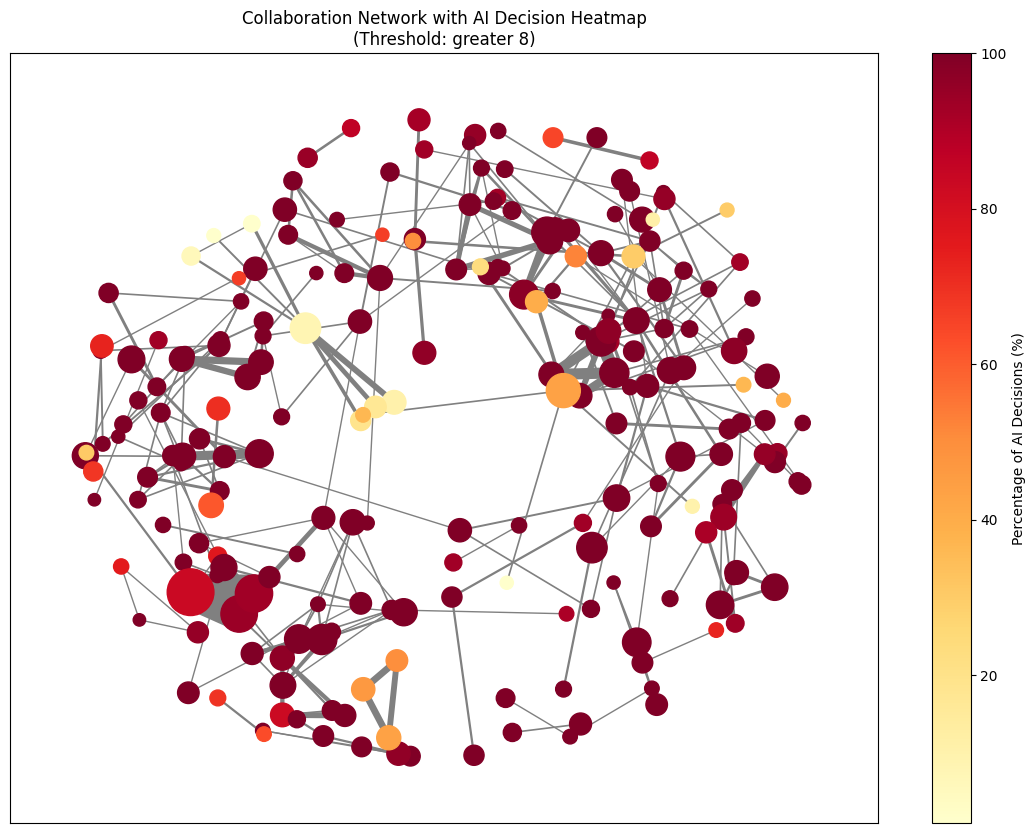

In [89]:
collaboration_network_graph(merged_data_pred, collaboration_threshold=8, filter_type="greater", csv_path="data/pred/metadata/communities_output.csv")

detected：42 communities
[community 1] author counts=23，members=[616, 1041, 1042, 1043, 1044, 1045, 1070, 1071, 1076, 1077, 1078, 1079, 1086, 1175, 1176, 1292, 1293, 1614, 2386, 2771, 2792, 5886, 7340]
[community 2] author counts=19，members=[93, 116, 117, 119, 382, 682, 683, 685, 1047, 1050, 1051, 1095, 1096, 1590, 3242, 3256, 3294, 5634, 5635]
[community 3] author counts=14，members=[1048, 1055, 1059, 1060, 1087, 1167, 1168, 1388, 1491, 1882, 2351, 2392, 5894, 12443]
[community 4] author counts=12，members=[69, 70, 100, 619, 664, 1194, 1915, 1916, 4251, 4256, 4887, 4888]
[community 5] author counts=12，members=[82, 621, 1046, 1068, 1069, 1080, 1084, 1180, 1181, 1186, 5887, 5888]
[community 6] author counts=9，members=[84, 599, 1159, 1160, 1275, 1431, 1432, 1433, 1434]
[community 7] author counts=9，members=[9116, 9117, 9264, 9266, 9281, 9383, 9735, 9766, 9770]
[community 8] author counts=8，members=[91, 606, 607, 1035, 1425, 1428, 1430, 1472]
[community 9] author counts=7，members=[52, 77, 78

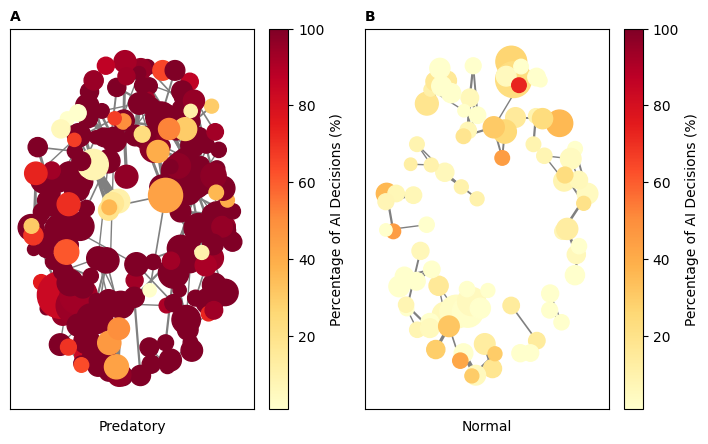

In [ ]:
import matplotlib.pyplot as plt

# Convert width from cm to inches
fig_width = 18.4 / 2.54  # ~7.24 inches
fig_height = 4.5  # adjust based on your desired aspect ratio

fig, axes = plt.subplots(1, 2, figsize=(fig_width, fig_height))

# Plot for Predatory
collaboration_network_graph(merged_data_pred, collaboration_threshold=8, filter_type="greater", ax=axes[0])
axes[0].text(0, 1.05, 'A', transform=axes[0].transAxes,
             fontsize=10, fontweight='bold', va='top', ha='left', family='sans-serif')
axes[0].set_title("Predatory", fontsize=10, family='sans-serif', y=-0.08)

# Plot for Regular
collaboration_network_graph(merged_data_good, collaboration_threshold=8, filter_type="greater", ax=axes[1])
axes[1].text(0, 1.05, 'B', transform=axes[1].transAxes,
             fontsize=10, fontweight='bold', va='top', ha='left', family='sans-serif')
axes[1].set_title("Normal", fontsize=10, family='sans-serif', y=-0.08)

plt.tight_layout()
plt.savefig("figure/collaboration_network_grid.png", format='png', bbox_inches='tight',dpi=300)

plt.show()


Check frequent collaborated author's afflication by name

In [96]:
import pandas as pd
from pathlib import Path

community_path = Path("data/pred/metadata/communities_output.csv")  
authors_path = Path("data/pred/metadata/pred_authors_country_affiliation.csv")
output_path = Path("data/pred/metadata/community_with_affiliation.csv")  

df_comm = pd.read_csv(community_path)  
df_auth = pd.read_csv(authors_path)    

df_comm["author_id"] = pd.to_numeric(df_comm["author_id"], errors="coerce")
df_auth["id"] = pd.to_numeric(df_auth["id"], errors="coerce")

df_auth_sorted = df_auth.sort_values(
    by=["affiliations"], ascending=[False], na_position="last"
)
df_auth_dedup = df_auth_sorted.drop_duplicates(subset=["id"], keep="first")

df_merge = df_comm.merge(
    df_auth_dedup[["id", "affiliations"]],
    left_on="author_id",
    right_on="id",
    how="left"
).drop(columns=["id"]).rename(columns={"affiliations": "Affiliation"})

df_merge.to_csv(output_path, index=False)

total = len(df_comm)
matched = df_merge["Affiliation"].notna().sum()


In [97]:
import pandas as pd
import re
from itertools import combinations
from collections import Counter

df = pd.read_csv("data/norm/metadata/community_with_affiliation.csv")

STOPWORDS = set("""
university college dept department school faculty division institute inst laboratory lab center centre hospital clinic
medical med medicine health healthcare engineering science sciences technology tech technological polytechnic poly
national state federal provincial municipal city town county
research teaching academic graduate undergraduate education
of the and & for in on at to from with without by de la le der die das und
usa germany france china india korea uk england
""".split())

def normalize_affil(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r"\S+@\S+", " ", text)
    text = re.sub(r"https?://\S+", " ", text)
    text = re.sub(r"[^a-z0-9]+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize_affil(text):
    t = normalize_affil(text)
    return set(tok for tok in t.split() if tok not in STOPWORDS and len(tok) > 2)

df["tokens"] = df["Affiliation"].apply(tokenize_affil)

def jacc(a, b):
    return len(a & b) / len(a | b) if a and b else 0.0

# ------- per-community analysis -------
community_results = []
all_sims = []

for cid, g in df.groupby("community_id"):
    tokens = list(g["tokens"])

    # pairwise similarities in this community
    pairs = list(combinations(tokens, 2))
    sims = [jacc(a, b) for a, b in pairs] if pairs else []

    # store for per-community report
    avg_sim = sum(sims)/len(sims) if sims else 0.0
    community_results.append((cid, len(tokens), round(avg_sim, 3)))

    # collect for overall report
    all_sims.extend(sims)

# ------- overall similarity -------
overall_similarity = sum(all_sims) / len(all_sims) if all_sims else 0.0

print("=== Per Community Affiliation Similarity ===")
for cid, n_authors, avg_sim in community_results:
    print(f"Community {cid}: authors={n_authors}, avg_similarity={avg_sim}")

print("\n=== Overall Affiliation Similarity ===")
print(f"Overall Average Similarity Across All Communities = {round(overall_similarity, 3)}")


=== Per Community Affiliation Similarity ===
Community 1: authors=9, avg_similarity=0.087
Community 2: authors=6, avg_similarity=0.689
Community 3: authors=5, avg_similarity=0.161
Community 4: authors=4, avg_similarity=0.067
Community 5: authors=4, avg_similarity=0.153
Community 6: authors=4, avg_similarity=0.53
Community 7: authors=4, avg_similarity=0.112
Community 8: authors=3, avg_similarity=0.0
Community 9: authors=3, avg_similarity=0.083
Community 10: authors=3, avg_similarity=0.222
Community 11: authors=3, avg_similarity=0.0
Community 12: authors=3, avg_similarity=0.298
Community 13: authors=3, avg_similarity=0.083
Community 14: authors=2, avg_similarity=0.2
Community 15: authors=2, avg_similarity=0.2
Community 16: authors=2, avg_similarity=1.0
Community 17: authors=2, avg_similarity=0.6
Community 18: authors=2, avg_similarity=0.125
Community 19: authors=2, avg_similarity=0.1
Community 20: authors=2, avg_similarity=0.0
Community 21: authors=2, avg_similarity=0.091
Community 22: a

In [98]:
import pandas as pd
import re
from itertools import combinations
from collections import Counter
from scipy.stats import ttest_ind, mannwhitneyu

pred_path = "data/pred/metadata/community_with_affiliation.csv"
norm_path = "data/norm/metadata/community_with_affiliation.csv"

STOPWORDS = set("""
university college dept department school faculty division institute inst laboratory lab center centre hospital clinic
medical med medicine health healthcare engineering science sciences technology tech technological polytechnic poly
national state federal provincial municipal city town county
research teaching academic graduate undergraduate education
of the and & for in on at to from with without by de la le der die das und
usa germany france china india korea uk england
""".split())

def normalize_affil(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r"\S+@\S+", " ", text)
    text = re.sub(r"https?://\S+", " ", text)
    text = re.sub(r"[^a-z0-9]+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize_affil(text):
    t = normalize_affil(text)
    return set(tok for tok in t.split() if tok not in STOPWORDS and len(tok) > 2)

def jacc(a, b):
    return len(a & b) / len(a | b) if a and b else 0.0

def compute_similarity(path):
    df = pd.read_csv(path)
    df["tokens"] = df["Affiliation"].apply(tokenize_affil)

    all_pair_sims = [] # Similarity of all author pairs (for overall)
    community_summary = [] # Statistics for each community

    for cid, g in df.groupby("community_id"):
        tokens = list(g["tokens"])

        pairs = list(combinations(tokens, 2))
        sims = [jacc(a, b) for a, b in pairs] if pairs else []

        if sims:
            avg_sim = sum(sims) / len(sims)
        else:
            avg_sim = 0.0

        community_summary.append({
            "community_id": cid,
            "n_authors": len(tokens),
            "avg_similarity": avg_sim,
        })

        all_pair_sims.extend(sims)

    # overall similarity
    overall = sum(all_pair_sims) / len(all_pair_sims) if all_pair_sims else 0.0

    return overall, community_summary, all_pair_sims


pred_overall, pred_comms, pred_sims = compute_similarity(pred_path)
norm_overall, norm_comms, norm_sims = compute_similarity(norm_path)

print("\n=== Results ===")
print(f"Pred   overall similarity: {pred_overall:.4f}")
print(f"Norm   overall similarity: {norm_overall:.4f}")

# ============ Statistical Tests ============ #
print("\n=== Statistical Tests ===")

# t-test
t_stat, t_p = ttest_ind(pred_sims, norm_sims, equal_var=False)
print(f"T-test:       t={t_stat:.3f}, p={t_p:.6f}")

# Mann-Whitney U test
u_stat, u_p = mannwhitneyu(pred_sims, norm_sims, alternative="two-sided")
print(f"Mann-Whitney: U={u_stat:.3f}, p={u_p:.6f}")




=== Results ===
Pred   overall similarity: 0.0431
Norm   overall similarity: 0.2261

=== Statistical Tests ===
T-test:       t=-6.427, p=0.000000
Mann-Whitney: U=32899.500, p=0.000000


Check frequent collaborated author's afflication by country

In [102]:
import pandas as pd
from pathlib import Path

community_path = Path("data/norm/metadata/communities_output.csv")
authors_path   = Path("data/norm/metadata/norm_authors_country_affiliation.csv")
output_path    = Path("data/norm/metadata/community_with_country.csv")

df_comm = pd.read_csv(community_path)     
df_auth = pd.read_csv(authors_path)       

df_comm["author_id"] = pd.to_numeric(df_comm["author_id"], errors="coerce")
df_auth["id"]         = pd.to_numeric(df_auth["id"], errors="coerce")

df_auth_sorted = df_auth.sort_values(
    by=["country"], ascending=[False], na_position="last"
)
df_auth_dedup = df_auth_sorted.drop_duplicates(subset=["id"], keep="first")

df_merge = df_comm.merge(
    df_auth_dedup[["id", "country"]],
    left_on="author_id",
    right_on="id",
    how="left"
).drop(columns=["id"]).rename(columns={"country": "Country"})

df_merge.to_csv(output_path, index=False)

total = len(df_comm)
matched = df_merge["Country"].notna().sum()
print(f"Total authors: {total}")
print(f"Matched countries: {matched} ({matched/total:.1%})")
print(f"Output saved to: {output_path}")


Total authors: 88
Matched countries: 86 (97.7%)
Output saved to: data/norm/metadata/community_with_country.csv


In [104]:
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu

pred_path = "data/pred/metadata/community_with_country.csv"
norm_path = "data/norm/metadata/community_with_country.csv"

def compute_country_consistency(path):
    df = pd.read_csv(path)

    df["Country"] = df["Country"].fillna("Unknown").astype(str)

    results = []

    for cid, g in df.groupby("community_id"):
        total = len(g)
        counts = g["Country"].value_counts()
        top_count = counts.iloc[0]
        consistency = top_count / total

        results.append({
            "community_id": cid,
            "n_authors": total,
            "top_country": counts.index[0],
            "consistency": consistency
        })

    result_df = pd.DataFrame(results)
    return result_df, result_df["consistency"].tolist()

norm_df, norm_vals = compute_country_consistency(norm_path)
pred_df, pred_vals = compute_country_consistency(pred_path)

print("=== Country Consistency Results ===")
print(f"Norm avg: {sum(norm_vals)/len(norm_vals):.4f}")
print(f"Pred avg: {sum(pred_vals)/len(pred_vals):.4f}")

print("\n=== Statistical Tests ===")

# t-test
t_stat, t_p = ttest_ind(pred_vals, norm_vals, equal_var=False)
print(f"T-test:       t={t_stat:.3f}, p={t_p:.6f}")

# Mann–Whitney U test
u_stat, u_p = mannwhitneyu(pred_vals, norm_vals, alternative="two-sided")
print(f"Mann-Whitney: U={u_stat:.3f}, p={u_p:.6f}")

# print("\nNorm sample:")
# print(norm_df.head())

# print("\nPred sample:")
# print(pred_df.head())


=== Country Consistency Results ===
Norm avg: 0.8024
Pred avg: 0.6058

=== Statistical Tests ===
T-test:       t=-3.595, p=0.000655
Mann-Whitney: U=357.500, p=0.001344
